In [2]:
import os, sys, email,re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud
import networkx as nx
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

In [4]:
emails_df = pd.read_csv('../input/enron-email-dataset/emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [5]:
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [6]:
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
emails_df['content'] = list(map(get_text_from_email, messages))
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [7]:
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding','X-From','X-To','X-cc','X-bcc','X-Folder','X-Origin','X-FileName','user'], axis=1)
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
emails_df.dtypes

Date       object
From       object
To         object
Subject    object
content    object
dtype: object

In [8]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    
    return normalized

In [9]:
analysis_df=emails_df[['From', 'To', 'Date','Subject','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]

In [10]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.content.apply(clean_text)

In [11]:
analysis_df.head()

,From,To,Date,Subject,content,clean_content
Message-ID,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,(phillip.allen@enron.com),(tim.belden@enron.com),2001-05-14 16:39:00-07:00,,Here is our forecast\n\n,forecast
<15464986.1075855378456.JavaMail.evans@thyme>,(phillip.allen@enron.com),(john.lavorato@enron.com),2001-05-04 13:51:00-07:00,Re:,Traveling to have a business meeting takes the...,traveling business meeting takes fun trip espe...
<24216240.1075855687451.JavaMail.evans@thyme>,(phillip.allen@enron.com),(leah.arsdall@enron.com),2000-10-18 03:00:00-07:00,Re: test,test successful. way to go!!!,test successful way go
<13505866.1075863688222.JavaMail.evans@thyme>,(phillip.allen@enron.com),(randall.gay@enron.com),2000-10-23 06:13:00-07:00,,"Randy,\n\n Can you send me a schedule of the s...",randy send schedule salary level everyone sche...
<30922949.1075863688243.JavaMail.evans@thyme>,(phillip.allen@enron.com),(greg.piper@enron.com),2000-08-31 05:07:00-07:00,Re: Hello,Let's shoot for Tuesday at 11:45.,let shoot tuesday


In [16]:
analysis_df.drop('content',axis=1)

,From,To,Date,Subject,clean_content
Message-ID,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,(phillip.allen@enron.com),(tim.belden@enron.com),2001-05-14 16:39:00-07:00,,forecast
<15464986.1075855378456.JavaMail.evans@thyme>,(phillip.allen@enron.com),(john.lavorato@enron.com),2001-05-04 13:51:00-07:00,Re:,traveling business meeting takes fun trip espe...
<24216240.1075855687451.JavaMail.evans@thyme>,(phillip.allen@enron.com),(leah.arsdall@enron.com),2000-10-18 03:00:00-07:00,Re: test,test successful way go
<13505866.1075863688222.JavaMail.evans@thyme>,(phillip.allen@enron.com),(randall.gay@enron.com),2000-10-23 06:13:00-07:00,,randy send schedule salary level everyone sche...
<30922949.1075863688243.JavaMail.evans@thyme>,(phillip.allen@enron.com),(greg.piper@enron.com),2000-08-31 05:07:00-07:00,Re: Hello,let shoot tuesday
...,...,...,...,...,...
<26807948.1075842029936.JavaMail.evans@thyme>,(john.zufferli@enron.com),(kori.loibl@enron.com),2001-11-28 13:30:11-08:00,Trade with John Lavorato,trade oil spec hedge ng john lavorato book joh...
<25835861.1075842029959.JavaMail.evans@thyme>,(john.zufferli@enron.com),(john.lavorato@enron.com),2001-11-28 12:47:48-08:00,Gas Hedges,position alberta term book send positions dire...
<28979867.1075842029988.JavaMail.evans@thyme>,(john.zufferli@enron.com),(dawn.doucet@enron.com),2001-11-28 07:20:00-08:00,RE: CONFIDENTIAL,original message doucet dawn sent wednesday no...


In [19]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

In [20]:
N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [21]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

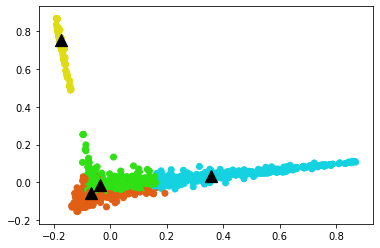

In [22]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()